### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import math

## Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7310,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7311,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7312,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Breve tratamento de dados

In [5]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828,NaN,NaN,NaN,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549,NaN,NaN,NaN,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459,NaN,NaN,NaN,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102,NaN,NaN,NaN,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731,NaN,NaN,NaN,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2,0.0,0.0,0.0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7310,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1,0.0,0.0,0.0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7311,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1,0.0,0.0,0.0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7312,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154.0,1,0.0,0.0,0.0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


### Criação de Variáveis

In [6]:
QuebrasFinal = QuebrasFinal[(QuebrasFinal["Nível de Tensão"] == "BT") | (QuebrasFinal["Nível de Tensão"] == "MT")].reset_index(drop=True)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828,NaN,NaN,NaN,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549,NaN,NaN,NaN,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459,NaN,NaN,NaN,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102,NaN,NaN,NaN,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731,NaN,NaN,NaN,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2,0.0,0.0,0.0,...,119.8,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3
7055,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2,0.0,0.0,0.0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7056,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1,0.0,0.0,0.0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7057,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1,0.0,0.0,0.0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1


### Tipo de tensão

In [7]:
QuebrasFinal["Ser_BT?"] = np.where(QuebrasFinal["Nível de Tensão"] == "BT", 1, 0)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828,NaN,NaN,NaN,...,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0,0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549,NaN,NaN,NaN,...,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0,0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459,NaN,NaN,NaN,...,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0,0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102,NaN,NaN,NaN,...,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731,NaN,NaN,NaN,...,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2,0.0,0.0,0.0,...,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3,1
7055,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2,0.0,0.0,0.0,...,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0,1
7056,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1,0.0,0.0,0.0,...,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN,1
7057,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1,0.0,0.0,0.0,...,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1,1


### Causas

In [8]:
# Lista de categorias de causas de incidentes pertencentes a cada grande classe
humanos = ['Escavações', 'Abate De Árvores', 'Veículos', 'Incêndio', 'Malfeitoria/Vandalismo', 
           'Furtos', 'Risco Iminente Pessoas Ou Bens', 'Sabotagem', 'Trabalhos De Terceiros ( Gruas,... )', 
           'Intervenções À Superficie', 'Malfeitorioa (Vandalismo)', 'Desabamento De Muros/Outras Construções', 
         'Ruptura De Canal. De Fluídos', 'Desabamento De Muros/Outras Cons']

animais = ['Aves', 'Animais Não Aves', 'Corpos Estranhos Na Rede']

clima = ['Deslizamento De Terras', 'Terramoto', 'Neve/Gelo/Granizo Condição Excecional', 
         'Vento Intensidade Excepcional', 'Descarga Atmosférica Directa',  
         'Inundações Imprevisíveis']

# Função para atribuir a classe correspondente com base na causa do incidente
def assign_class(cause):
    if cause in humanos:
        return 'Humanos'
    elif cause in animais:
        return 'Animais'
    elif cause in clima:
        return 'Clima'
    else:
        return 'Outros'

# Criar uma nova coluna com as classes atribuídas
QuebrasFinal['Grande Classe'] = QuebrasFinal['Causa do incidente'].apply(assign_class)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Grande Classe
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828,NaN,NaN,NaN,...,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0,0,Humanos
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549,NaN,NaN,NaN,...,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0,0,Humanos
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459,NaN,NaN,NaN,...,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0,0,Clima
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102,NaN,NaN,NaN,...,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1,Humanos
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731,NaN,NaN,NaN,...,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9,0,Animais
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2,0.0,0.0,0.0,...,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3,1,Humanos
7055,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2,0.0,0.0,0.0,...,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0,1,Humanos
7056,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1,0.0,0.0,0.0,...,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN,1,Humanos
7057,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1,0.0,0.0,0.0,...,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1,1,Humanos


In [9]:
# Criar variáveis dummy
dummies = pd.get_dummies(QuebrasFinal["Grande Classe"])

# Concatenar as variáveis dummy ao DataFrame original
QuebrasFinal = pd.concat([QuebrasFinal, dummies], axis=1)

# Excluir a coluna original "Grande Classe"
QuebrasFinal.drop("Grande Classe", axis=1, inplace=True)

# Exibir o DataFrame com as variáveis dummy
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Clima,Humanos
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828,NaN,NaN,NaN,...,2.6,NaN,NaN,NaN,NaN,0.0,0,False,False,True
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549,NaN,NaN,NaN,...,6.2,249.0,270.0,2.8,8.1,0.0,0,False,False,True
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459,NaN,NaN,NaN,...,12.9,197.0,180.0,3.9,14.4,4.0,0,False,True,False
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102,NaN,NaN,NaN,...,9.1,288.0,225.0,3.6,13.9,13.2,1,False,False,True
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731,NaN,NaN,NaN,...,2.2,137.0,118.0,4.1,15.4,15.9,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2,0.0,0.0,0.0,...,6.1,28.0,326.0,NaN,NaN,1.3,1,False,False,True
7055,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2,0.0,0.0,0.0,...,6.3,NaN,NaN,NaN,NaN,0.0,1,False,False,True
7056,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1,0.0,0.0,0.0,...,14.8,NaN,NaN,NaN,NaN,NaN,1,False,False,True
7057,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1,0.0,0.0,0.0,...,14.6,NaN,NaN,NaN,NaN,8.1,1,False,False,True


### Tempo Trigonometria

In [10]:
# Função para verificar se o ano é bissexto
def eh_bissexto(ano):
    return ano % 4 == 0 and (ano % 100 != 0 or ano % 400 == 0)

# Função para calcular o ângulo em radianos com base no dia, mês e ano
def calcular_angulo(dia, mes, ano):
    total_dias = 366 if eh_bissexto(ano) else 365  # Total de dias no ano
    angulo = 2 * np.pi * ((mes - 1) * 31 + dia) / total_dias
    return angulo

# Função para calcular o ângulo para cada linha do DataFrame
def calcular_angulo_para_linha(row):
    dia = row['Dia']
    mes = row['Mês']
    ano = row['Ano']
    return calcular_angulo(dia, mes, ano)

# Aplicar a função calcular_angulo_para_linha em cada linha do DataFrame QuebrasFinal
QuebrasFinal['RadianoData'] = QuebrasFinal.apply(calcular_angulo_para_linha, axis=1)

# Aplicar as funções seno e cosseno aos ângulos
QuebrasFinal['SenoData'] = np.sin(QuebrasFinal['RadianoData'])
QuebrasFinal['CossenoData'] = np.cos(QuebrasFinal['RadianoData'])

# Verificar o resultado
QuebrasFinal[['Dia', 'Mês', 'RadianoData', 'SenoData', 'CossenoData']]

,Dia,Mês,RadianoData,SenoData,CossenoData
0,2,1,0.034428,0.034422,0.999407
1,2,1,0.034428,0.034422,0.999407
2,4,1,0.068857,0.068802,0.997630
3,5,1,0.086071,0.085965,0.996298
4,9,1,0.154928,0.154309,0.988023
...,...,...,...,...,...
7054,25,11,5.766759,-0.493776,0.869589
7055,29,11,5.835616,-0.432776,0.901502
7056,3,11,5.388047,-0.780296,0.625411
7057,23,11,5.732331,-0.523416,0.852078


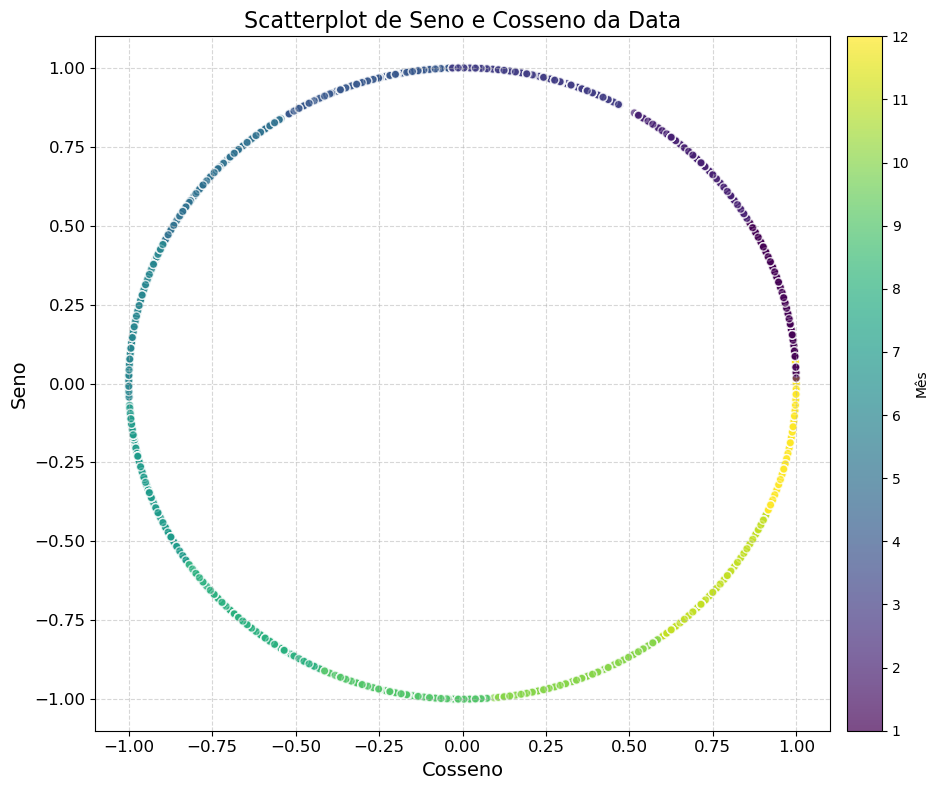

In [13]:
# Plotar o scatterplot
plt.figure(figsize=(10, 8))
plt.scatter(QuebrasFinal['CossenoData'], QuebrasFinal['SenoData'], c=QuebrasFinal['Mês'], cmap='viridis', alpha=0.7, edgecolors='w')
plt.title('Scatterplot de Seno e Cosseno da Data', fontsize=16)
plt.xlabel('Cosseno', fontsize=14)
plt.ylabel('Seno', fontsize=14)
plt.colorbar(label='Mês', ticks=range(1, 13), pad=0.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
kkk

NameError: name 'kkk' is not defined

### Apagar colunas

In [ ]:
columnsRemove = ['Nível de Tensão', 'Causa do incidente']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

## Estandardizar/Normalizar os dados

In [ ]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

In [ ]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

## Imputação dos dados

In [ ]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


In [ ]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

In [ ]:
sns.set(style="whitegrid")

# Selecionar apenas as primeiras 6 colunas
subset_quebras_final = QuebrasFinal.iloc[:, 5:13]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.boxplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

## Modelling

In [ ]:
# Selecionar apenas as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number])

# Valores de k que você deseja testar
k_values = range(2, 7)

# Lista para armazenar os valores de silhueta média
silhouette_scores = []

# Iterar sobre os valores de k
for k in k_values:
    # Criar o modelo de clustering K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Treinar o modelo nos dados
    kmeans.fit(colunas_numericas)
    # Obter as etiquetas de cluster para cada ponto
    labels = kmeans.labels_
    # Calcular o score de silhueta
    silhouette_avg = silhouette_score(colunas_numericas, labels)
    # Armazenar o score de silhueta na lista
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Método do Cotovelo
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhueta Média')
plt.title('Método da Silhueta para Determinar k (Variáveis Numéricas)')
plt.show()


In [ ]:
# Reduzir a dimensionalidade dos dados para 2 dimensões usando t-SNE
tsne = TSNE(n_components=2, random_state=69)
data_2d = tsne.fit_transform(colunas_numericas)

# Plotar os pontos em um gráfico de dispersão, colorindo-os de acordo com os clusters
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.title('Visualização dos Clusters com t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Gerar dados de exemplo
X, _ = make_blobs(n_samples=150, centers=5, random_state=42)

# Executar o algoritmo de clustering hierárquico
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(X)

# Função para plotar o dendrograma
def plot_dendrogram(model, **kwargs):
    # Calcula o layout do dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # folha
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plota o dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Plotando o dendrograma
plt.figure(figsize=(10, 5))
plt.title('Dendrograma Hierárquico')
plot_dendrogram(model)
plt.xlabel('Índice do Amostra')
plt.ylabel('Distância')
plt.grid(False)
plt.show()

In [ ]:
# Inicialize o modelo Agglomerative Clustering com o número desejado de clusters
n_clusters = 3  # Defina o número de clusters desejado
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Ajuste o modelo aos dados
agg_clustering.fit(colunas_numericas)

# Obtenha as etiquetas de cluster para cada amostra
cluster_labels = agg_clustering.labels_

# Adicione as etiquetas de cluster ao DataFrame QuebrasFinal
colunas_numericas['Cluster_Agglomerative'] = cluster_labels

In [ ]:
# Calcule a silhouette média para o modelo
silhouette_avg = silhouette_score(colunas_numericas, cluster_labels)
print("Silhouette média para o modelo Agglomerative Clustering:", silhouette_avg)

# Calcule a silhouette para cada amostra
sample_silhouette_values = silhouette_samples(colunas_numericas, cluster_labels)

# Crie um gráfico de barras para mostrar a silhouette para cada amostra
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(n_clusters):
    # Agregue a silhouette para amostras pertencentes ao cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiqueta do cluster no meio
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule o próximo y_lower para o próximo gráfico
    y_lower = y_upper + 10  

plt.title("Gráfico de Silhouette para Agglomerative Clustering")
plt.xlabel("Valor de silhouette")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Linha para indicar a silhouette média
plt.yticks([])  # Limpe os yticks
plt.show()


In [ ]:
colunas_numericas

In [ ]:
# Agrupar os dados por cluster e calcular as médias
cluster_means = colunas_numericas.groupby('Cluster_Agglomerative').mean()

# Definir cores para os clusters
colors = ['blue', 'green', 'orange', 'red']

# Plotar os gráficos de barras para cada cluster
for i, cluster in enumerate(cluster_means.index):
    cluster_data = cluster_means.loc[cluster]
    plt.figure(figsize=(10, 6))
    plt.barh(cluster_data.index, cluster_data.values, color=colors[i])
    plt.title(f'Médias das Variáveis para o Cluster {cluster}')
    plt.xlabel('Média')
    plt.ylabel('Variável')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
# Supondo que 'clusters' seja a coluna de clusters em QuebrasFinal
clusters = colunas_numericas['Cluster_Agglomerative']

# Adicionando a coluna de clusters ao DataFrame Quebras
QuebrasFinal['Cluster_Agglomerative'] = clusters

In [ ]:
# Agrupar os dados por causa do incidente e cluster e contar o número de ocorrências em cada grupo
causa_cluster_counts = QuebrasFinal.groupby(['Causa do incidente', 'Cluster_Agglomerative']).size().unstack(fill_value=0)

# Plotar o gráfico de barras empilhadas para cada causa do incidente
causa_cluster_counts.plot(kind='bar', stacked=True, figsize=(16, 12))
plt.title('Quantidade de Incidentes por Causa e Cluster')
plt.xlabel('Causa do Incidente')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Agrupar os dados por 'nt' e 'Cluster_Agglomerative' e contar o número de ocorrências em cada grupo
nt_cluster_counts = QuebrasFinal.groupby(['Nível de Tensão', 'Cluster_Agglomerative']).size().unstack(fill_value=0)

# Calcular a porcentagem de ocorrências de cada cluster para cada valor de 'nt'
nt_cluster_percentages = nt_cluster_counts.div(nt_cluster_counts.sum(axis=1), axis=0) * 100

# Plotar gráficos circulares para a porcentagem de clusters em cada valor de 'nt'
for nt_value, nt_cluster_percentage in nt_cluster_percentages.iterrows():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(nt_cluster_percentage, labels=nt_cluster_percentage.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Porcentagem de Clusters em "nt" = {nt_value}')
    plt.tight_layout()
    # plt.savefig(f'Porcentagem_Clusters_nt_{nt_value}.svg')
    plt.show()


In [ ]:
# Criar a tabela pivô
pivot_table = QuebrasFinal.pivot_table(index='Concelho', columns='Cluster_Agglomerative', aggfunc='size', fill_value=0)

# Renomear as colunas
pivot_table.columns = ['Cluster_' + str(col) for col in pivot_table.columns]

# Exibir a tabela pivô
pivot_table
pivot_table['Cluster_2'].idxmax()

In [ ]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'Concelho'}, inplace=True)
Concelho["Concelho"] = Concelho["Concelho"].str.title()
Concelho = Concelho[~Concelho['Distrito'].isin(['Azores', 'Madeira'])]
Concelho

In [ ]:
Bilada = set(pivot_table.index) - set(Concelho["Concelho"])
Bilada

In [ ]:
Freguesias_com_clusters = Concelho.merge(pivot_table, left_on='Concelho', right_index=True, how="left")
Freguesias_com_clusters.fillna(0, inplace=True)
Freguesias_com_clusters

In [ ]:
# Configurar a figura e os eixos para a grade de subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Iterar sobre cada cluster e plotar o mapa correspondente
for i, cluster in enumerate(['Cluster_0', 'Cluster_1', 'Cluster_2']):
    # Plotar o mapa das freguesias para o cluster atual
    Freguesias_com_clusters.plot(column=cluster, cmap='RdYlGn_r', linewidth=0.8, edgecolor='black', ax=axs[i], legend=True)
    
    # Adicionar título para cada subplot
    axs[i].set_title(f'Mapa do Cluster {i}', fontsize=14)

# Exibir os mapas
plt.tight_layout()
plt.show()


In [ ]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_0', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

In [ ]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_1', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

In [ ]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_2', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()